# SciPy solve_ivp example for 1<sup>st</sup> order ordinary differential equation

## Modelled system 1

We'll start with a simple ODE to demonstrate what the SciPy's solve_ivp function needs as arguments and what it outputs

The modelled system is a 1<sup>st</sub> order ODE

\begin{equation*}
    \frac{\mathrm{d}x}{\mathrm{d}t} = 2t
\end{equation*}

which has an analytical solution 

\begin{equation*}
    x(\mathrm{t}) = t^2 + C
\end{equation*}

With a condition that links x to certain time we can determine the constant C and solve the system precisely.

For example given x(t=0) = 3 we would get

\begin{align*}
    x(t\mathrm{=0}) &= 0^2 + C \\
    3 &= C \\
    C &= 3 
\end{align*}

We'll start familiriazing ourselves with solve_ivp by first solving this system with our own numerical method (explicit Euler's method) and then running solve_ivp and comparing the solutions we get. We'll use $x(t=0) = 3$ as our initial condition and solve the system in domain $t \in [0, 10]$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as widgets
%matplotlib widget

### Euler's method

Euler's method is the simplest method to solve ODEs. The working principle of the method is to approximate the derivative $\frac{\mathrm{d}x}{\mathrm{d}t}$ with a discrete from  $\frac{\Delta x}{\Delta t}$

\begin{align*}
    \frac{\Delta x}{\Delta t} &= \frac{\mathrm{d}x}{\mathrm{d}t} \\
    \frac{x_{n+1}-x_{n}}{t_{n+1} - t_n} &= \frac{\mathrm{d}x}{\mathrm{d}t} \\
    x_{n+1}-x_{n} &= \frac{\mathrm{d}x}{\mathrm{d}t}(t_{n+1} - t_n) \\
    x_{n+1} &= x_n + \frac{\mathrm{d}x}{\mathrm{d}t}(t_{n+1} - t_n) \\
    x_{n+1} &= x_n  + \frac{\mathrm{d}x}{\mathrm{d}t}h
\end{align*}
where $ h = (t_{n+1} - t_n) $ is the step size we want to take

Let's create a function that implements the Euler's method for any given x(t=0),$ \frac{\mathrm{d}x}{\mathrm{d}t}$ and h

In [16]:
def euler(x0: float, dxdt: callable, h: float, t_end: float):
    t_start = 0
    N_points = int(t_end/h) + 1
    xt = np.zeros((N_points,))
    times = np.array([0+h*i for i in range(N_points)])
    xt[0] = x0
    for ind, t in enumerate(times[1:]):
        xt[ind+1] = dxdt(t)*h + xt[ind]

    return(times, xt)
    
odefun = lambda t: 2*t

solution = euler(3, odefun, h=1, t_end=10)
print(solution)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([  3.,   5.,   9.,  15.,  23.,  33.,  45.,  59.,  75.,  93., 113.]))
[3, 4, 7, 12, 19, 28, 39, 52, 67, 84, 103]


In [24]:
np.linspace(0,10, 101)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

### Visualize the Euler's method solution with h=1, h=0.1, h=0.01 and exact solution

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
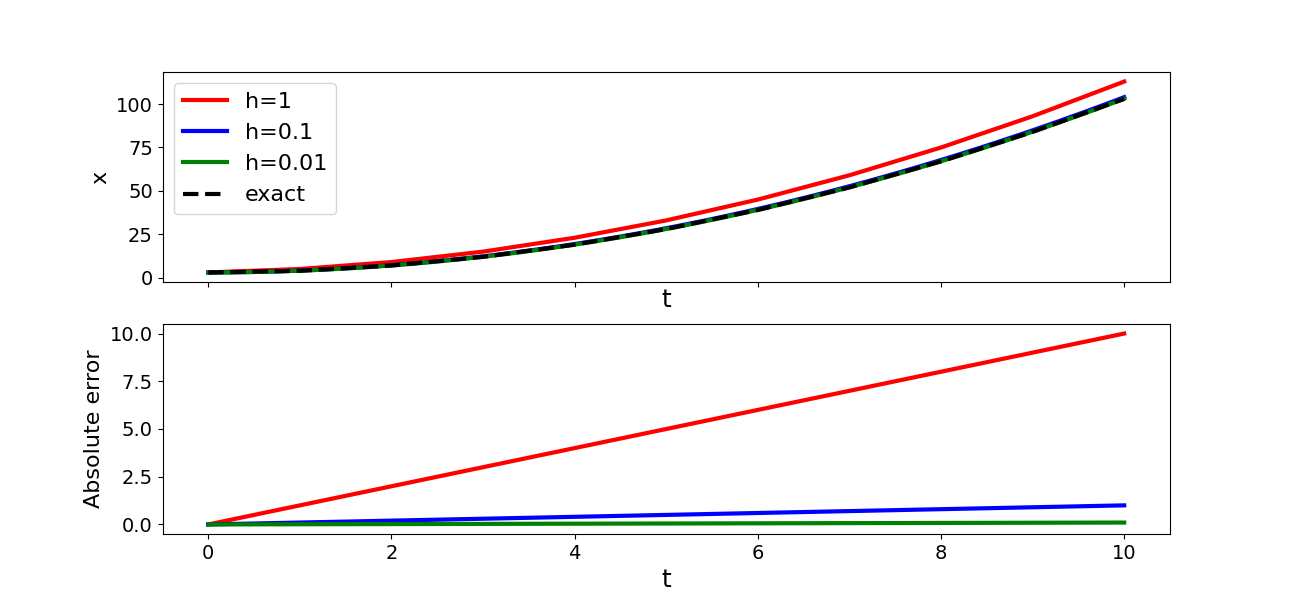

In [34]:
sol1 = euler(3, odefun, h=1, t_end=10)
sol2 = euler(3, odefun, h=0.1, t_end=10)
sol3 = euler(3, odefun, h=0.01, t_end=10)
exact_t = np.array([t for t in range(11)])
exact_x = [t**2+3 for t in range(11)]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13,6), sharex=True)

sols = [sol1, sol2, sol3, (exact_t, exact_x)]

colors = ['r','b','g','k']
linestyles = ['-','-','-','--']
labels = ['h=1', 'h=0.1','h=0.01', 'exact']
for i,s in enumerate(sols):
    ax[0].plot(s[0], s[1], color=colors[i], linestyle=linestyles[i], label=labels[i], linewidth=3)
    if i < 3:
        exact = np.array([t**2+3 for t in np.linspace(0,10, num=s[0].shape[0])])
        ax[1].plot(s[0], s[1]-exact, '-', color=colors[i], linewidth=3)
ax[0].legend(loc='upper left', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[1].set_ylabel('Absolute error', fontsize=16)
for a in ax:
    a.tick_params(axis='both', labelsize=14)
    a.set_xlabel('t', fontsize=18)



## Solve system 1 using SciPy's solve_ivp

In [43]:
odefun = lambda t: 2.0*t

sol = solve_ivp(lambda t,y : odefun(t), (0, 10), [3], t_eval=np.arange(0,11))

print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
 t_events: None
        y: array([[  3.,   4.,   7.,  12.,  19.,  28.,  39.,  52.,  67.,  84., 103.]])
 y_events: None


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
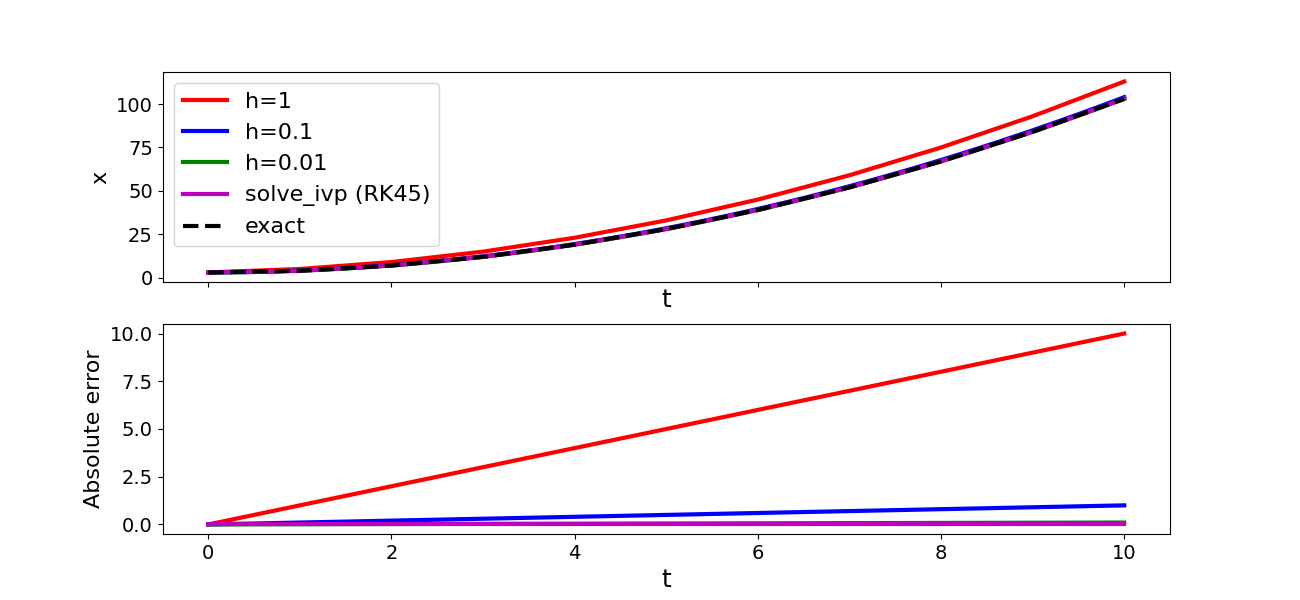

In [44]:
sol1 = euler(3, odefun, h=1, t_end=10)
sol2 = euler(3, odefun, h=0.1, t_end=10)
sol3 = euler(3, odefun, h=0.01, t_end=10)
exact_t = np.array([t for t in range(11)])
exact_x = [t**2+3 for t in range(11)]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13, 6), sharex=True)

sols = [sol1, sol2, sol3, (sol.t, sol.y.reshape(sol.y.shape[1],)), (exact_t, exact_x)]

colors = ['r', 'b', 'g', 'm', 'k']
linestyles = ['-', '-', '-', '-', '--']
labels = ['h=1', 'h=0.1', 'h=0.01', 'solve_ivp (RK45)', 'exact']
for i, s in enumerate(sols):
    ax[0].plot(s[0], s[1], color=colors[i], linestyle=linestyles[i], label=labels[i], linewidth=3)
    if i < 4:
        exact = np.array([t**2+3 for t in np.linspace(0, 10, num=s[0].shape[0])])
        ax[1].plot(s[0], s[1]-exact, '-', color=colors[i], linewidth=3)
ax[0].legend(loc='upper left', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[1].set_ylabel('Absolute error', fontsize=16)
for a in ax:
    a.tick_params(axis='both', labelsize=14)
    a.set_xlabel('t', fontsize=18)
